In [ ]:
# Google Colab에서 Kaggle API를 사용하기 위한 라이브러리 설치
!pip install kaggle

# Kaggle API 토큰 업로드
from google.colab import files
files.upload()

In [ ]:
# 업로드한 Kaggle API 토큰 파일 확인
ls -1ha kaggle.json

kaggle.json


In [ ]:
# Kaggle API 토큰을 사용자 디렉토리로 복사하고 권한 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Kaggle에서 데이터셋 다운로드
!kaggle datasets download -d hetulmehta/website-classification

  0% 0.00/2.00M [00:00<?, ?B/s]
100% 2.00M/2.00M [00:00<00:00, 32.5MB/s]


In [ ]:
!ls

kaggle.json  sample_data  website-classification.zip


In [ ]:
# 다운로드한 데이터셋 압축 해제
!unzip website-classification.zip

Archive:  website-classification.zip
  inflating: website_classification.csv  


In [ ]:
import pandas as pd

# CSV 파일을 DataFrame으로 읽기
df = pd.read_csv('website_classification.csv')

# 각 열에서 결측값 확인
missing_values = df.isnull().sum()

# 각 열의 결측값 개수 출력
print("Missing Values:")
print(missing_values)

# DataFrame 전체에 결측값이 있는지 확인
any_missing = df.isnull().sum().any()

if any_missing:
    print("There are missing values in the DataFrame.")
else:
    print("There are no missing values in the DataFrame.")

Missing Values:
Unnamed: 0              0
website_url             0
cleaned_website_text    0
Category                0
dtype: int64
There are no missing values in the DataFrame.


In [ ]:
# CSV 파일을 다시 읽어서 새로운 DataFrame으로 저장
wc_data = pd.read_csv('website_classification.csv')
# 'Category'가 'Streaming Services'인 행의 'Outlook'에 1 할당
wc_data.loc[wc_data['Category'] == 'Streaming Services', 'Outlook'] = 1
# 'Category'가 'Streaming Services'가 아닌 행의 'Outlook'에 0 할당
wc_data.loc[wc_data['Category'] != 'Streaming Services', 'Outlook'] = 0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(pd.DataFrame(wc_data, columns=['cleaned_website_text']))
y = np.array(pd.DataFrame(wc_data, columns=['Outlook']))

# y를 1D 배열로 변환하기 위해 ravel() 사용
y = y.ravel()

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.flatten())
X_test_tfidf = tfidf_vectorizer.transform(X_test.flatten())

In [ ]:
from sklearn.svm import SVC

# SVM 모델 훈련
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 테스트 데이터에 대한 예측
predictions_svm = svm_classifier.predict(X_test_tfidf)

# SVM 모델 평가
accuracy_svm = accuracy_score(y_test, predictions_svm)
print(f'SVM Accuracy: {accuracy_svm}')

# SVM 분류 보고서 출력
print('SVM Classification Report:')
print(classification_report(y_test, predictions_svm))

# SVM 혼동 행렬 출력
print('SVM Confusion Matrix:')
print(confusion_matrix(y_test, predictions_svm))

SVM Accuracy: 0.9914772727272727
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       327
         1.0       1.00      0.88      0.94        25

    accuracy                           0.99       352
   macro avg       1.00      0.94      0.97       352
weighted avg       0.99      0.99      0.99       352

SVM Confusion Matrix:
[[327   0]
 [  3  22]]


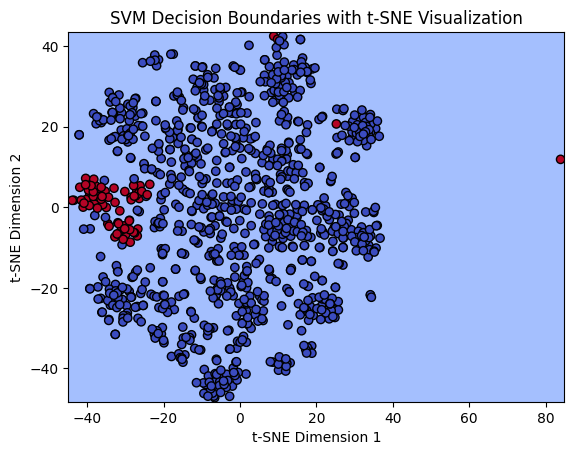

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

X = np.array(pd.DataFrame(wc_data, columns=['cleaned_website_text']))
y = np.array(pd.DataFrame(wc_data, columns=['Outlook']))
y = y.ravel()

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y)

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.flatten())
X_test_tfidf = tfidf_vectorizer.transform(X_test.flatten())

# SVM 모델 훈련
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

# t-SNE를 사용하여 결정 경계 시각화
tsne = TSNE(n_components=2, random_state=42, init="random")  # init을 "random"으로 변경
X_train_tsne = tsne.fit_transform(X_train_tfidf.toarray())  # 희소 행렬을 밀집 배열로 변환

# 감소된 차원 데이터에 SVM 분류기 적용
svm_classifier.fit(X_train_tsne, y_train)

# 시각화를 위한 메쉬그리드 생성
h = .02
x_min, x_max = X_train_tsne[:, 0].min() - 1, X_train_tsne[:, 0].max() + 1
y_min, y_max = X_train_tsne[:, 1].min() - 1, X_train_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 결정 경계 플로팅
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')
plt.title("SVM Decision Boundaries with t-SNE Visualization")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

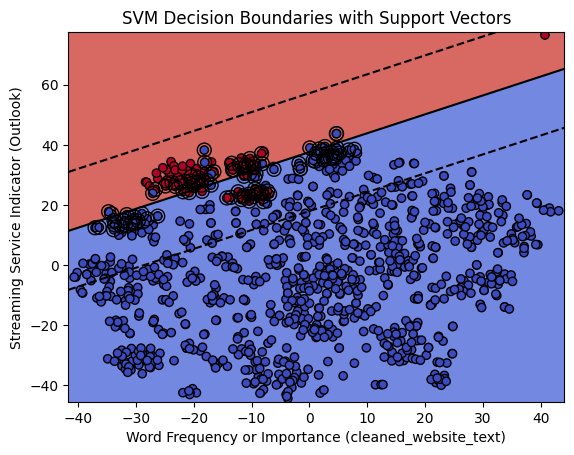

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

X = np.array(pd.DataFrame(wc_data, columns=['cleaned_website_text']))
y = np.array(pd.DataFrame(wc_data, columns=['Outlook']))
y = y.ravel()

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y)

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.flatten())
X_test_tfidf = tfidf_vectorizer.transform(X_test.flatten())

# SVM 모델 훈련
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train_tfidf, y_train)

# t-SNE를 사용하여 결정 경계 시각화
tsne = TSNE(n_components=2, random_state=42, init="random")  # init을 "random"으로 변경
X_train_tsne = tsne.fit_transform(X_train_tfidf.toarray())  # 희소 행렬을 밀집 배열로 변환

# 감소된 차원 데이터에 SVM 분류기 적용
svm_classifier.fit(X_train_tsne, y_train)

# 시각화를 위한 메쉬그리드 생성
h = .02
x_min, x_max = X_train_tsne[:, 0].min() - 1, X_train_tsne[:, 0].max() + 1
y_min, y_max = X_train_tsne[:, 1].min() - 1, X_train_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 결정 경계 플로팅
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')

# 결정 경계, 마진 및 서포트 벡터 플로팅
decisions = svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
support_vectors = svm_classifier.support_vectors_
margin = 1 / np.sqrt(np.sum(svm_classifier.coef_ ** 2))

plt.contour(xx, yy, decisions.reshape(xx.shape), levels=[-margin, 0, margin], colors='k', linestyles=['--', '-', '--'])
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', marker='o')

plt.title("SVM Decision Boundaries with Support Vectors")
plt.xlabel('Word Frequency or Importance (cleaned_website_text)')
plt.ylabel('Streaming Service Indicator (Outlook)')
plt.show()